Notebook to investigate performance of convolution methods

In [1]:
import numpy as np
from scipy.signal import convolve
from scipy.signal import oaconvolve

In [2]:
from euphonic.cli.utils import (load_data_from_file, _grid_spec_from_args, _get_energy_bins)
from euphonic.util import mp_grid, mode_gradients_to_widths
from euphonic import ureg
from typing import Optional
from scipy.optimize import nnls
import warnings; warnings.simplefilter('ignore')

def import_real_data(filename, grid_space):
    data = load_data_from_file(filename)

    recip_length_unit = ureg('1 /angstrom')
    grid_spec = _grid_spec_from_args(data.crystal, grid=None,
                                        grid_spacing=(grid_space
                                                    * recip_length_unit))

    # for adaptive broadening
    modes, mode_grads = data.calculate_qpoint_phonon_modes(mp_grid(grid_spec), return_mode_gradients=True)
    mode_widths = mode_gradients_to_widths(mode_grads, modes.crystal.cell_vectors)

    modes.frequencies_unit = 'hartree'
    return modes, mode_widths

def bin_data(modes, bin_no):

    bin_no = int(bin_no+1)
    ebins = _get_energy_bins(modes, bin_no)

    dos = modes._calculate_dos(ebins)
    bins = ebins.to('hartree').magnitude
    bin_mp = bins[:-1] + 0.5*np.diff(bins)
    freqs = modes.frequencies.magnitude

    return dos, bins, bin_mp, freqs

modes, mode_widths = import_real_data('/home/jessfarmer/Broadening_Methods/Data/mp-147-20180417.yaml', 0.1)
data_real, bins_real, bin_mp_real, frequencies_real = bin_data(modes, 5000)
mode_weights = np.ones(frequencies_real.shape)

mode_widths = mode_widths.to('hartree').magnitude

n_qpts = len(frequencies_real)
weights = np.full(n_qpts, 1/n_qpts)

def fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, conv_method):
    freqs = np.ravel(frequencies_real)
    mode_widths = np.ravel(mode_widths)
    combined_weights = np.ravel(mode_weights * weights[:, np.newaxis])

    # coefficients determined from a polynomial fit to plot of
    # error vs spacing value
    spacing = np.polyval([656.1, -131.8, 15.98, 1.0803], 0.01)
    bin_width = bins_real[1]-bins_real[0]
    mode_widths = np.maximum(mode_widths, bin_width / 2)

    n_kernels = int(
        np.ceil(np.log(max(mode_widths)/min(mode_widths))/np.log(spacing)))
    mode_width_samples = spacing**np.arange(n_kernels+1)*min(mode_widths)
    # Determine frequency range for gaussian kernel, the choice of
    # 3*max(sigma) is arbitrary but tuned for acceptable error/peformance
    freq_range = 3*max(mode_widths)

    kernel_npts_oneside = np.ceil(freq_range/bin_width)
    kernels = gaussian(np.arange(-kernel_npts_oneside,
                        kernel_npts_oneside+1, 1)*bin_width,
                        mode_width_samples[:, np.newaxis])*bin_width
    kernels_idx = np.searchsorted(mode_width_samples, mode_widths)

    lower_coeffs = find_coeffs(spacing)
    scaled_data_matrix = np.zeros((len(bins_real)-1, len(kernels)))
    # start loop from 1 as points with insert-position 0 lie outside of bin range
    for i in range(1, len(mode_width_samples)):
        masked_block = (kernels_idx == i)
        sigma_factors = mode_widths[masked_block]/mode_width_samples[i-1]
        lower_mix = np.polyval(lower_coeffs, sigma_factors)
        upper_mix = 1-lower_mix

        lower_hist, _ = np.histogram(
            freqs[masked_block], bins=bins_real,
            weights=lower_mix*combined_weights[masked_block]/bin_width)
        upper_hist, _ = np.histogram(
            freqs[masked_block], bins=bins_real,
            weights=upper_mix*combined_weights[masked_block]/bin_width)

        scaled_data_matrix[:, i-1] += lower_hist
        scaled_data_matrix[:, i] += upper_hist

    if conv_method == 'oa':
        dos = np.sum([oaconvolve(scaled_data_matrix[:, i], kernels[i],
                 mode="same") for i in range(0, n_kernels)], 0)
    else:
        dos = np.sum([convolve(scaled_data_matrix[:, i], kernels[i],
                 mode="same", method=conv_method) for i in range(0, n_kernels)], 0)
    return dos

def gaussian(xvals: np.ndarray,
             sigma: np.ndarray,
             centre: Optional[int] = 0) -> np.ndarray:
    """
    Evaluates the Gaussian function.
    Parameters
    ----------
    xvals
        Float ndarray. Points at which the Gaussian function should be
        evaluated
    sigma
        Float ndarray. Specifies the standard deviation for the gaussian
    centre
        Optional integer value that sets the centre of the gaussian
    Returns
    -------
    gauss_eval
        Float ndarray containing the values of the evaluated gaussian function
    """
    # evaluate gaussian function with defined sigma and center at x
    gauss_eval = np.exp(-0.5 * ((xvals - centre) / sigma)**2) \
                    / (sigma * np.sqrt(2 * np.pi))
    return gauss_eval


def find_coeffs(spacing: float) -> np.ndarray:
    """"
    Function that, for a given spacing value, gives the coefficients of the
    polynomial which decsribes the relationship between sigma and the
    linear combination weights determined by optimised interpolation

    Parameters
    ----------
    spacing
        Scalar float. The spacing value between sigma samples at which
        the gaussian kernel is exactly calculated.

    Returns
    -------
    coeffs
        Array containing the polynomial coefficients, with the highest
        power first
    """
    sigma_values = np.linspace(1, spacing, 10)
    x_range = np.linspace(-10, 10, 101)
    actual_gaussians = gaussian(x_range, sigma_values[:,np.newaxis])
    lower_mix = np.zeros(len(sigma_values))
    ref_gaussians = actual_gaussians[[0, -1]].T

    for i in range(len(sigma_values)):
        actual_gaussian = actual_gaussians[i]
        res = nnls(ref_gaussians, actual_gaussian)[0]
        lower_mix[i] = res[0]

    coeffs = np.polyfit(sigma_values, lower_mix, 3)
    return coeffs


Firstly, we can time the difference between using direct, overlap add, and fft convolution. It can be seen that fft is fastest in this case, and choosing either the fft or direct method is faster than choosing the auto method which selects either fft or direct depending on the given inputs. Meanwhile the overlap add method is the slowest choice.

In [10]:
%timeit fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "direct")

47.1 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%timeit fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "fft")

42.5 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
%timeit fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "oa")

52.2 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "auto")

48.2 ms ± 806 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The plot below illustrates how the speed of convolution varies with both the data used, and the number of bins. In general, the fft and overlap add methods scale better than the direct method when the number of bins are increased.

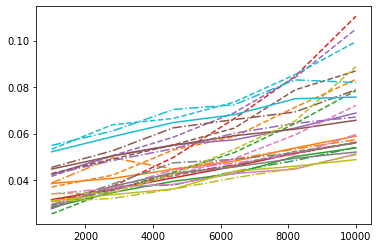

In [10]:
import timeit
import matplotlib.pyplot as plt

filenames = ['mp-147-20180417.yaml', 'mp-200-20180417.yaml', 'mp-226-20180417.yaml',
            'mp-661-20180417.yaml', 'mp-830-20180417.yaml', 'mp-917-20180417.yaml',
            'mp-1818-20180417.yaml', 'mp-2319-20180417.yaml', 'mp-7041-20180417.yaml']

plt.figure()

for (filename, colour) in zip(filenames, ['C1','C2','C3','C4','C5','C6','C7','C8','C9']):

    save_times_direct = []
    save_times_fft = []
    save_times_oa = []
    modes, mode_widths = import_real_data('/home/jessfarmer/Broadening_Methods/Data/'+filename, 0.1)
    mode_widths = mode_widths.to('hartree').magnitude
    for bin_no in np.linspace(1000,10000, 6):

        data_real, bins_real, bin_mp_real, frequencies_real = bin_data(modes, bin_no)

        mode_weights = np.ones(frequencies_real.shape)

        n_qpts = len(frequencies_real)
        weights = np.full(n_qpts, 1/n_qpts)

        def run_fun_direct():
            fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "direct")

        run_time_direct = timeit.Timer(stmt=run_fun_direct).repeat(5,1)

        def run_fun_fft():
            fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "fft")

        run_time_fft = timeit.Timer(stmt=run_fun_fft).repeat(5,1)

        def run_fun_oa():
            fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "oa")

        run_time_oa = timeit.Timer(stmt=run_fun_oa).repeat(5,1)

        save_times_direct.append(np.mean(run_time_direct))
        save_times_fft.append(np.mean(run_time_fft))
        save_times_oa.append(np.mean(run_time_oa))

    plt.plot(np.linspace(1000,10000, 6), save_times_direct, colour, linestyle='--')
    plt.plot(np.linspace(1000,10000,6), save_times_oa, colour, linestyle='-.')
    plt.plot(np.linspace(1000,10000, 6), save_times_fft, colour)


Finally, it should be checked that the methods produce similar results. Plotting the resulting dos for one of the sample datasets, it can be seen that the three methods produce visually identical results.

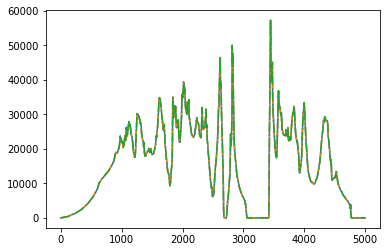

In [18]:
modes, mode_widths = import_real_data('/home/jessfarmer/Broadening_Methods/Data/mp-147-20180417.yaml', 0.1)
mode_widths = mode_widths.to('hartree').magnitude

data_real, bins_real, bin_mp_real, frequencies_real = bin_data(modes, 5000)
mode_weights = np.ones(frequencies_real.shape)

n_qpts = len(frequencies_real)
weights = np.full(n_qpts, 1/n_qpts)

dos_direct = fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "direct")
dos_fft = fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "fft")
dos_oa = fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "oa")

plt.figure()
plt.plot(dos_direct)
plt.plot(dos_fft, '--')
plt.plot(dos_oa, '-.')

Over the 9 different datasets tested, the largest difference between the convolved spectra was 3.49e-10, meaning the convolution methods produce very similar results.

In [17]:
for filename in filenames:
    modes, mode_widths = import_real_data('/home/jessfarmer/Broadening_Methods/Data/'+filename, 0.1)
    mode_widths = mode_widths.to('hartree').magnitude

    data_real, bins_real, bin_mp_real, frequencies_real = bin_data(modes, bin_no)

    mode_weights = np.ones(frequencies_real.shape)

    n_qpts = len(frequencies_real)
    weights = np.full(n_qpts, 1/n_qpts)

    dos_fft = fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "direct")

    dos_direct = fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "fft")

    dos_oa = fast_broaden(bins_real, frequencies_real, mode_widths, weights, mode_weights, "oa")

    diff_fft_direct = max(abs(dos_fft-dos_direct))
    diff_fft_oa = max(abs(dos_fft-dos_oa))
    diff_oa_direct = max(abs(dos_oa-dos_direct))

    max_diff = max([diff_fft_direct, diff_fft_oa, diff_oa_direct])
    print(max_diff)

2.9103830456733704e-11
3.4924596548080444e-10
5.820766091346741e-11
1.0913936421275139e-11
1.4551915228366852e-11
2.9103830456733704e-11
4.3655745685100555e-11
1.0913936421275139e-11
2.1827872842550278e-11
